In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
image_size = (128, 128)
batch_size = 32

In [30]:
res_net_101 = tf.keras.applications.ResNet101(include_top=False,
                                              weights='imagenet',
                                             input_shape=image_size+(3,))

In [31]:
res_net_101.summary()

Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                      

In [32]:
len(res_net_101.layers)

345

In [33]:
layers_finetune = 10

In [34]:
res_net_101.trainable = True

# for layer in res_net_101.layers[:len(res_net_101.layers) - layers_finetune]:
#     layer.trainable = False

In [35]:
res_net_101.summary(show_trainable=True)

Model: "resnet101"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            Y          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             Y          
                                                                                                             
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           Y          
                                                                                                             
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          Y  

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory('Training/', 
                                                        image_size=image_size,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        shuffle=True,
                                                        seed=10)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [5]:
class_names = train_data.class_names

In [6]:
num_classes = len(class_names)

In [7]:
val_data = tf.keras.utils.image_dataset_from_directory('Training/',
                                                      image_size=image_size,
                                                      validation_split=0.2,
                                                      subset='validation',
                                                      shuffle=True,
                                                      seed=10)

Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [8]:
test_data = tf.keras.utils.image_dataset_from_directory('Testing/',
                                                       image_size=image_size,
                                                       batch_size=32,
                                                       shuffle=False,
                                                       seed=10)

Found 1311 files belonging to 4 classes.


In [9]:
rescale_fn = tf.keras.layers.Rescaling(scale=1./255)

train_data = train_data.map(lambda x, y: (rescale_fn(x), y))
val_data = val_data.map(lambda x, y: (rescale_fn(x), y))
test_data = test_data.map(lambda x, y: (rescale_fn(x), y))

In [42]:
cnn = tf.keras.Sequential([
    res_net_101,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [43]:
cnn.compile(optimizer = 'adam',   
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
            metrics = ['accuracy'])

In [44]:
history = cnn.fit(train_data,
       validation_data=val_data,
       epochs=15)

Epoch 1/15
143/143 [==============================] - 393s 3s/step - loss: 1.2350 - accuracy: 0.7295 - val_loss: 3.3674 - val_accuracy: 0.2189
Epoch 2/15
143/143 [==============================] - 364s 3s/step - loss: 0.2954 - accuracy: 0.8976 - val_loss: 3.9250 - val_accuracy: 0.2189
Epoch 3/15
143/143 [==============================] - 368s 3s/step - loss: 0.1823 - accuracy: 0.9398 - val_loss: 1.9436 - val_accuracy: 0.2189
Epoch 4/15
143/143 [==============================] - 365s 3s/step - loss: 0.1159 - accuracy: 0.9630 - val_loss: 3.3066 - val_accuracy: 0.2215
Epoch 5/15
143/143 [==============================] - 366s 3s/step - loss: 0.2731 - accuracy: 0.9313 - val_loss: 151.6006 - val_accuracy: 0.3336
Epoch 6/15
143/143 [==============================] - 366s 3s/step - loss: 0.2006 - accuracy: 0.9392 - val_loss: 1.3175 - val_accuracy: 0.6191
Epoch 7/15
143/143 [==============================] - 368s 3s/step - loss: 0.1757 - accuracy: 0.9446 - val_loss: 4.7622 - val_accuracy: 0.32

In [45]:
y_pred = cnn.predict(test_data)

41/41 [==============================] - 31s 716ms/step


In [46]:
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [47]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [48]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [49]:
accuracy_score(y_true, y_pred)

0.84744469870328

In [50]:
cnn.save('saved_models/resnet_scratch.keras')

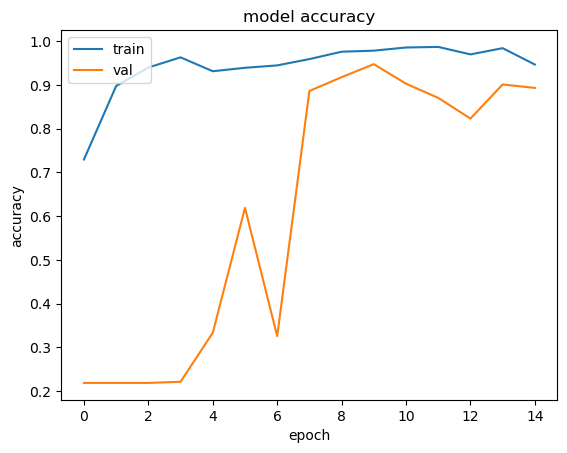

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

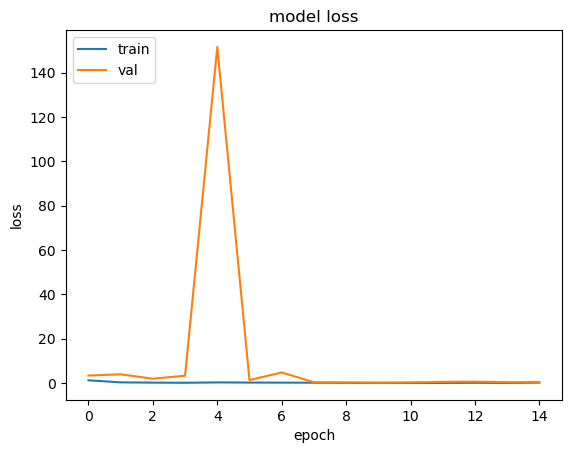

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
cnn2 = tf.keras.models.load_model('saved_models/resnet101_allTrain.keras')

In [20]:
y_pred = cnn2.predict(test_data)

41/41 [==============================] - 35s 813ms/step


In [21]:
y_pred = tf.argmax(y_pred, axis=1).numpy()

In [22]:
y_true = []
for images, labels in test_data:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [24]:
accuracy_score(y_true, y_pred)

0.84744469870328

In [25]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[242,  50,   3,   5],
       [  4, 226,  73,   3],
       [  0,  19, 386,   0],
       [  2,  40,   1, 257]], dtype=int64)

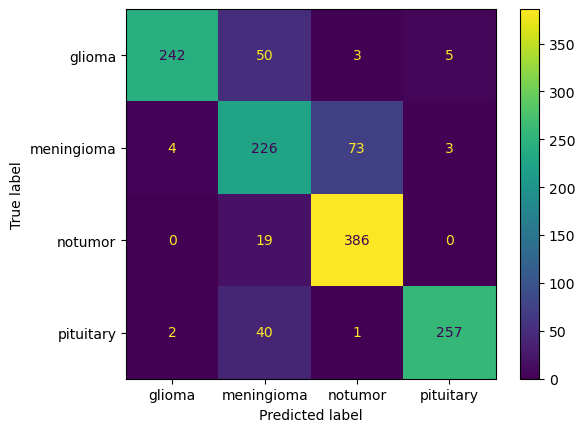

In [26]:
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot()
plt.show()

In [27]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      glioma       0.98      0.81      0.88       300
  meningioma       0.67      0.74      0.71       306
     notumor       0.83      0.95      0.89       405
   pituitary       0.97      0.86      0.91       300

    accuracy                           0.85      1311
   macro avg       0.86      0.84      0.85      1311
weighted avg       0.86      0.85      0.85      1311

